# 📊 Multinomial Logistic Regression Model for Student Outcome Prediction

## 🎯 **Notebook Overview**

This notebook implements and optimizes a **Multinomial Logistic Regression classifier** to predict student academic outcomes in online learning environments. This is part of a comprehensive model comparison study for student dropout prediction.

### 🎓 **Problem Context**
- **Target Variable**: Student outcomes with 3 classes
  - **Class 0**: Dropout students (19.1% - minority class)
  - **Class 1**: At-risk students (25.4%)
  - **Class 2**: Successful students (55.5% - majority class)

## 🏆 **Key Results Summary**

### 📊 **Model Performance**
- **Dropout Recall (Primary Metric)**: **66.84%** - Successfully identifies 2/3 of at-risk students
- **Test Accuracy**: 48.08% - Overall classification performance
- **F1-Weighted**: 48.80% - Balanced precision-recall performance
- **F1-Macro**: 41.57% - Unweighted class performance

### ⚙️ **Optimal Configuration**
- **Regularization**: L1 penalty (feature selection)
- **Regularization Strength**: C = 0.01 (strong regularization)
- **Solver**: SAGA (handles L1 penalty efficiently)
- **Class Weighting**: Custom dropout-focused weights {0: 2.09, 1: 1.31, 2: 0.48}

### 🎯 **Top Predictive Features**
1. **excellent_Score** (0.3293) - Academic excellence indicator
2. **active_in_VLE** (0.2363) - Virtual learning engagement
3. **student_engagement** (0.1390) - Overall engagement level

### 💡 **Key Insights**
- **Dropout Detection**: Model prioritizes identifying at-risk students over overall accuracy
- **Feature Selection**: L1 regularization automatically selected most relevant features
- **Class Imbalance**: Custom weighting successfully improved minority class detection

---

## 🔧 **Technical Details**

### **Key Features**
- **Class Imbalance Handling**: Custom class weighting strategies to improve dropout detection
- **Hyperparameter Optimization**: Comprehensive GridSearchCV with 450+ parameter combinations
- **Custom Scoring Metrics**: Dropout-focused metrics to prioritize identifying at-risk students
- **Feature Importance Analysis**: Coefficient analysis to understand model decision-making
- **Comprehensive Evaluation**: Cross-validation, confusion matrices, and detailed performance reports

### 📈 **Optimization Strategy**
- **Primary Goal**: Maximize **dropout recall** (detecting students who will drop out)
- **Secondary Goals**: Balance precision and overall model performance
- **Regularization**: Tests L1, L2, and ElasticNet penalties for feature selection and overfitting prevention

### 🔗 **Integration**
This notebook is part of a systematic model comparison framework that evaluates multiple algorithms (Random Forest, KNN, LightGBM, SVM, Neural Networks) to identify the best approach for student outcome prediction.

---


In [45]:
# ================================================================
# MULTINOMIAL LOGISTIC REGRESSION MODEL OPTIMIZATION
# ================================================================
# This notebook implements a comprehensive Multinomial Logistic Regression
# classifier with hyperparameter optimization using GridSearchCV.
# ================================================================

# ================================================================
# 1: Import Libraries
# ================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')
import time
import os
import joblib
import json
from datetime import datetime

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('default')
sns.set_palette([ "#1f4e79" ])   # a strong, navy‑blue

print("📚 Libraries imported successfully!")

📚 Libraries imported successfully!


In [46]:
# ================================================================
# 2. LOAD SAVED DATA
# ================================================================
print("📂 Loading saved training and test data...")
print("=" * 50)

try:
    # Load features
    X_train_lr = pd.read_csv('../Data/output/X_train_encoded.csv')
    X_test_lr = pd.read_csv('../Data/output/X_test_encoded.csv')
    
    # Load labels
    y_train_lr = pd.read_csv('../Data/output/y_train.csv').squeeze()  # squeeze() converts DataFrame to Series
    y_test_lr = pd.read_csv('../Data/output/y_test.csv').squeeze()
    
    print("✅ Data loaded successfully!")
    print(f"   Training features: {X_train_lr.shape}")
    print(f"   Test features: {X_test_lr.shape}")
    print(f"   Training labels: {y_train_lr.shape}")
    print(f"   Test labels: {y_test_lr.shape}")
    
except FileNotFoundError as e:
    print(f"❌ Error: Could not find data files. {e}")
    print("Make sure you've run the encoding notebook first!")
except Exception as e:
    print(f"❌ Error loading data: {e}")

📂 Loading saved training and test data...
✅ Data loaded successfully!
   Training features: (22180, 20)
   Test features: (5545, 20)
   Training labels: (22180,)
   Test labels: (5545,)


In [47]:
# ================================================================
# 3. ANALYZE CLASS DISTRIBUTION (DETERMINES BEST SCORING METRIC)
# ================================================================

print("📊 ANALYZING CLASS DISTRIBUTION")
print("=" * 50)

# Check target variable distribution using your training data
class_counts = pd.Series(y_train_lr).value_counts().sort_index()
class_percentages = pd.Series(y_train_lr).value_counts(normalize=True).sort_index() * 100

print("Class distribution in training data:")
for class_label, count in class_counts.items():
    percentage = class_percentages[class_label]
    print(f"  Class {class_label}: {count:,} samples ({percentage:.1f}%)")

# Calculate imbalance ratio
max_class_count = class_counts.max()
min_class_count = class_counts.min()
imbalance_ratio = max_class_count / min_class_count

print(f"\n📈 Imbalance Analysis:")
print(f"  Largest class: {max_class_count:,} samples")
print(f"  Smallest class: {min_class_count:,} samples")
print(f"  Imbalance ratio: {imbalance_ratio:.2f}:1")

# Determine best scoring metric - Focus on dropout detection
if imbalance_ratio > 2.0:
    print("⚠️  Dataset appears imbalanced - Using dropout-focused metrics")
    recommended_scoring = 'dropout_recall'
    scoring_explanation = "Dropout recall prioritizes identifying at-risk students (class 0)"
else:
    print("✅ Dataset appears balanced - accuracy is acceptable")
    recommended_scoring = 'accuracy'
    scoring_explanation = "Accuracy is reliable for balanced datasets"

print(f"🎯 Recommended scoring: {recommended_scoring}")
print(f"💡 Why: {scoring_explanation}")

📊 ANALYZING CLASS DISTRIBUTION
Class distribution in training data:
  Class 0: 4,237 samples (19.1%)
  Class 1: 5,634 samples (25.4%)
  Class 2: 12,309 samples (55.5%)

📈 Imbalance Analysis:
  Largest class: 12,309 samples
  Smallest class: 4,237 samples
  Imbalance ratio: 2.91:1
⚠️  Dataset appears imbalanced - Using dropout-focused metrics
🎯 Recommended scoring: dropout_recall
💡 Why: Dropout recall prioritizes identifying at-risk students (class 0)


In [48]:
# ================================================================
# 4. DEFINE PARAMETER GRIDS (CHOOSE YOUR SPEED VS THOROUGHNESS)
# ================================================================

print(f"\n🔧 PARAMETER GRID OPTIONS")
print("=" * 50)

# Calculate different class weight strategies
classes = np.unique(y_train_lr)
# Strategy 1: Sklearn's balanced weights
balanced_weights = compute_class_weight('balanced', classes=classes, y=y_train_lr)
# Conservative precision adjustment (minimal changes)
custom_weights = {
    0: balanced_weights[0] * 1.2,  
    1: balanced_weights[1] * 1.0,          
    2: balanced_weights[2] * 0.8
}

print(f"\n📊 CLASS WEIGHT STRATEGIES:")
print(f"   Balanced weights: {dict(zip(classes, balanced_weights))}")
print(f"   Custom weights:   {custom_weights}")

# Option 1: FAST Grid (15-25 minutes)
fast_param_grid = {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [1000],
    'class_weight': ['balanced', custom_weights]
}

# Option 2: COMPREHENSIVE Grid (45-60 minutes)
comprehensive_param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [1000, 2000, 3000],
    'class_weight': ['balanced', custom_weights],
    'l1_ratio': [0.5]  # Only used when penalty='elasticnet'
}

# Option 3: SMART Grid (25-35 minutes) - RECOMMENDED
smart_param_grid = [
    # L2 regularization with various solvers
    {
        'C': [0.01, 0.1, 1.0, 10.0, 100.0],
        'penalty': ['l2'],
        'solver': ['newton-cg', 'lbfgs', 'sag'],
        'max_iter': [1000, 2000],
        'class_weight': ['balanced', custom_weights]
    },
    # L1 regularization (only with compatible solvers)
    {
        'C': [0.01, 0.1, 1.0, 10.0, 100.0],
        'penalty': ['l1'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [1000, 2000],
        'class_weight': ['balanced', custom_weights]
    },
    # Elastic Net (only with saga solver)
    {
        'C': [0.1, 1.0, 10.0],
        'penalty': ['elasticnet'],
        'solver': ['saga'],
        'l1_ratio': [0.1, 0.5, 0.9],
        'max_iter': [2000],
        'class_weight': ['balanced', custom_weights]
    }
]

# Choose which grid to use (CHANGE THIS IF TO TRY DIFFERENT SPEED)
#chosen_param_grid = smart_param_grid  # RECOMMENDED
#grid_name = "SMART"

chosen_param_grid = comprehensive_param_grid
grid_name = "COMPREHENSIVE"

# Calculate combinations for list of dictionaries
def count_combinations(param_grid_list):
    total = 0
    for grid in param_grid_list:
        combinations = 1
        for values in grid.values():
            combinations *= len(values) if isinstance(values, list) else 1
        total += combinations
    return total

if isinstance(chosen_param_grid, list):
    total_combinations = count_combinations(chosen_param_grid)
else:
    total_combinations = np.prod([len(v) for v in chosen_param_grid.values()])

print(f"🎯 Using {grid_name} parameter grid")
print(f"📊 Total combinations to test: {total_combinations}")

if grid_name == "FAST":
    print("⏱️  Estimated time: 1-2 minutes")
elif grid_name == "SMART":
    print("⏱️  Estimated time: 2-5 minutes")
else:
    print("⏱️  Estimated time: 5-10 minutes")


🔧 PARAMETER GRID OPTIONS

📊 CLASS WEIGHT STRATEGIES:
   Balanced weights: {0: 1.7449453229486271, 1: 1.312270737190865, 2: 0.6006445148536301}
   Custom weights:   {0: 2.0939343875383525, 1: 1.312270737190865, 2: 0.48051561188290415}
🎯 Using COMPREHENSIVE parameter grid
📊 Total combinations to test: 450
⏱️  Estimated time: 5-10 minutes


In [49]:
# ================================================================
# 5. SETUP MULTI-SCORING GRIDSEARCHCV WITH CUSTOM DROPOUT METRICS
# ================================================================

print(f"\n🎯 GRIDSEARCHCV CONFIGURATION")
print("=" * 50)

# Define multiple scoring metrics including custom dropout-focused metrics
scoring_metrics = {
    'accuracy': 'accuracy',
    'f1_weighted': 'f1_weighted',
    'f1_macro': 'f1_macro',
    'precision_weighted': 'precision_weighted',
    'recall_weighted': 'recall_weighted',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro'
}

# Custom scoring for dropout-specific metrics
def dropout_recall_scorer(estimator, X, y):
    """Custom scorer for dropout (class 0) recall"""
    y_pred = estimator.predict(X)
    return recall_score(y, y_pred, labels=[0], average='macro')

def dropout_precision_scorer(estimator, X, y):
    """Custom scorer for dropout (class 0) precision"""
    y_pred = estimator.predict(X)
    return precision_score(y, y_pred, labels=[0], average='macro')

def at_risk_recall_scorer(estimator, X, y):
    """Custom scorer for at-risk students (classes 0,1) recall"""
    y_pred = estimator.predict(X)
    return recall_score(y, y_pred, labels=[0, 1], average='macro')

# Add custom scorers
scoring_metrics.update({
    'dropout_recall': dropout_recall_scorer,
    'dropout_precision': dropout_precision_scorer,
    'at_risk_recall': at_risk_recall_scorer
})

cv_folds = 5
recommended_scoring = 'dropout_recall'  # Focus on catching dropouts

print(f"🎯 Primary scoring metric: {recommended_scoring}")
print(f"📊 Total metrics tracked: {len(scoring_metrics)}")
print(f"🔍 Custom metrics: dropout_recall, dropout_precision, at_risk_recall")
print(f"🔄 Cross-validation folds: {cv_folds}")
print(f"💻 Parallel processing: Enabled (n_jobs=-1)")

# Configure GridSearchCV
grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=42, multi_class='multinomial'),
    param_grid=chosen_param_grid,
    scoring=scoring_metrics,
    refit=recommended_scoring,  # Refit using dropout recall
    cv=cv_folds,               # n-fold CV for reasonable speed
    n_jobs=-1,                 # Use all CPU cores
    verbose=2,                 # Show detailed progress
    return_train_score=True    # Track overfitting
)


🎯 GRIDSEARCHCV CONFIGURATION
🎯 Primary scoring metric: dropout_recall
📊 Total metrics tracked: 10
🔍 Custom metrics: dropout_recall, dropout_precision, at_risk_recall
🔄 Cross-validation folds: 5
💻 Parallel processing: Enabled (n_jobs=-1)


In [50]:
# ================================================================
# 6. RUN GRIDSEARCHCV
# ================================================================

print(f"\n🚀 STARTING GRIDSEARCHCV...")
print("=" * 50)
print("📝 This will show detailed progress. Please wait...")

start_time = time.time()

# Fit GridSearchCV using your training data
grid_search.fit(X_train_lr, y_train_lr)

total_time = time.time() - start_time
print(f"\n✅ GridSearchCV COMPLETED!")
print(f"⏱️  Total runtime: {total_time:.1f} seconds ({total_time/60:.1f} minutes)")

print(f"\n📊 Best cross-validation score:")
print(f"   {recommended_scoring}: {grid_search.best_score_:.4f}")


🚀 STARTING GRIDSEARCHCV...
📝 This will show detailed progress. Please wait...
Fitting 5 folds for each of 450 candidates, totalling 2250 fits

✅ GridSearchCV COMPLETED!
⏱️  Total runtime: 243.2 seconds (4.1 minutes)

📊 Best cross-validation score:
   dropout_recall: 0.6684


In [51]:
# ================================================================
# 7. EXTRACT AND DISPLAY RESULTS
# ================================================================

print(f"\n🏆 GRIDSEARCHCV RESULTS")
print("=" * 60)

# Display best parameters
print(f"🎯 BEST PARAMETERS (optimized for {recommended_scoring}):")
for param, value in grid_search.best_params_.items():
    print(f"   {param:20s}: {value}")

# Display best cross-validation scores for all metrics
print(f"\n📊 BEST CROSS-VALIDATION SCORES:")
cv_results = grid_search.cv_results_
best_index = grid_search.best_index_

for metric_name, metric_key in scoring_metrics.items():
    score_key = f'mean_test_{metric_name}'
    std_key = f'std_test_{metric_name}'
    
    if score_key in cv_results:
        mean_score = cv_results[score_key][best_index]
        std_score = cv_results[std_key][best_index]
        print(f"   {metric_name:20s}: {mean_score:.4f} ± {std_score:.4f}")


🏆 GRIDSEARCHCV RESULTS
🎯 BEST PARAMETERS (optimized for dropout_recall):
   C                   : 0.01
   class_weight        : {0: 2.0939343875383525, 1: 1.312270737190865, 2: 0.48051561188290415}
   l1_ratio            : 0.5
   max_iter            : 1000
   penalty             : l1
   solver              : saga

📊 BEST CROSS-VALIDATION SCORES:
   accuracy            : 0.4692 ± 0.0065
   f1_weighted         : 0.4738 ± 0.0064
   f1_macro            : 0.3980 ± 0.0050
   precision_weighted  : 0.5721 ± 0.0133
   recall_weighted     : 0.4692 ± 0.0065
   precision_macro     : 0.4730 ± 0.0179
   recall_macro        : 0.4502 ± 0.0056
   dropout_recall      : 0.6684 ± 0.0308
   dropout_precision   : 0.2495 ± 0.0060
   at_risk_recall      : 0.3959 ± 0.0083


In [52]:
# ================================================================
# 8. EVALUATE BEST MODEL ON TEST SET
# ================================================================

print(f"\n🔮 FINAL MODEL EVALUATION ON TEST SET")
print("=" * 60)

# Get the best model (already trained)
best_lr_model = grid_search.best_estimator_

# Make predictions on your test set
print("📊 Making predictions on test set...")
y_pred_test = best_lr_model.predict(X_test_lr)

# Calculate test set metrics
test_accuracy = accuracy_score(y_test_lr, y_pred_test)
test_f1_weighted = f1_score(y_test_lr, y_pred_test, average='weighted')
test_f1_macro = f1_score(y_test_lr, y_pred_test, average='macro')

print(f"\n📈 TEST SET PERFORMANCE:")
print(f"   Accuracy:     {test_accuracy:.4f}")
print(f"   F1-Weighted:  {test_f1_weighted:.4f}")
print(f"   F1-Macro:     {test_f1_macro:.4f}")


🔮 FINAL MODEL EVALUATION ON TEST SET
📊 Making predictions on test set...

📈 TEST SET PERFORMANCE:
   Accuracy:     0.4808
   F1-Weighted:  0.4880
   F1-Macro:     0.4157


In [53]:
# ================================================================
# 9. DETAILED CLASSIFICATION REPORT
# ================================================================

print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
print("=" * 60)
print(classification_report(y_test_lr, y_pred_test))


📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.26      0.65      0.38      1059
           1       0.38      0.16      0.22      1410
           2       0.75      0.57      0.65      3076

    accuracy                           0.48      5545
   macro avg       0.46      0.46      0.42      5545
weighted avg       0.56      0.48      0.49      5545




📊 CREATING CONFUSION MATRIX...

📋 CONFUSION MATRIX (Plain Text):
Predicted     0    1     2
Actual                    
0           692  115   252
1           862  224   324
2          1072  254  1750


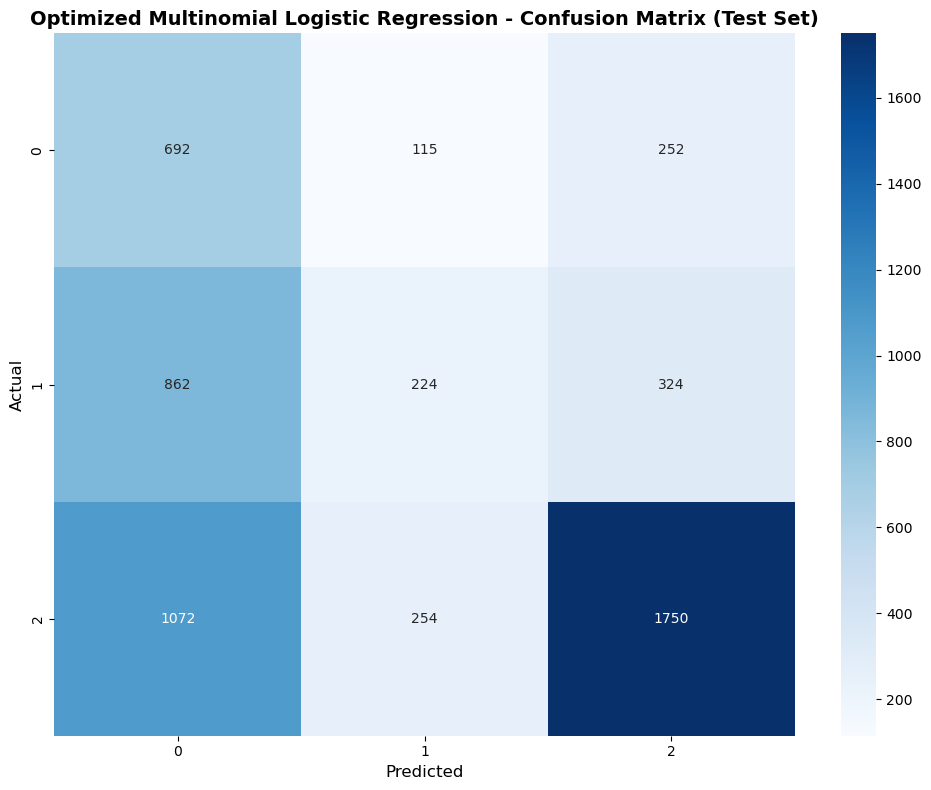

In [54]:
# ================================================================
# 10. CONFUSION MATRIX VISUALIZATION
# ================================================================

print(f"\n📊 CREATING CONFUSION MATRIX...")

# Calculate confusion matrix
cm = confusion_matrix(y_test_lr, y_pred_test)

# Get unique class labels
class_labels = sorted(np.unique(y_train_lr))

# Create plain-text confusion matrix table
print(f"\n📋 CONFUSION MATRIX (Plain Text):")
print("=" * 50)
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
cm_df.index.name = 'Actual'
cm_df.columns.name = 'Predicted'
print(cm_df)
print("=" * 50)

# Create confusion matrix plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Optimized Multinomial Logistic Regression - Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.tight_layout()
plt.show()

In [55]:
# ================================================================
# 11. TOP 5 PARAMETER COMBINATIONS
# ================================================================

print(f"\n🔍 TOP 5 PARAMETER COMBINATIONS")
print("=" * 60)

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(grid_search.cv_results_)
primary_score_col = f'mean_test_{recommended_scoring}'

# Get top 5 combinations
top_5_results = results_df.nlargest(5, primary_score_col)

print(f"🏆 Top 5 combinations (ranked by {recommended_scoring}):")
print("-" * 80)

for i, (idx, row) in enumerate(top_5_results.iterrows(), 1):
    score = row[primary_score_col]
    std_score = row[f'std_test_{recommended_scoring}']
    params = row['params']
    
    print(f"{i}. Score: {score:.4f} ± {std_score:.4f}")
    print(f"   Parameters: {params}")
    print()


🔍 TOP 5 PARAMETER COMBINATIONS
🏆 Top 5 combinations (ranked by dropout_recall):
--------------------------------------------------------------------------------
1. Score: 0.6684 ± 0.0308
   Parameters: {'C': 0.01, 'class_weight': {0: 2.0939343875383525, 1: 1.312270737190865, 2: 0.48051561188290415}, 'l1_ratio': 0.5, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'saga'}

2. Score: 0.6684 ± 0.0308
   Parameters: {'C': 0.01, 'class_weight': {0: 2.0939343875383525, 1: 1.312270737190865, 2: 0.48051561188290415}, 'l1_ratio': 0.5, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'saga'}

3. Score: 0.6684 ± 0.0308
   Parameters: {'C': 0.01, 'class_weight': {0: 2.0939343875383525, 1: 1.312270737190865, 2: 0.48051561188290415}, 'l1_ratio': 0.5, 'max_iter': 3000, 'penalty': 'l1', 'solver': 'saga'}

4. Score: 0.6122 ± 0.0252
   Parameters: {'C': 0.01, 'class_weight': {0: 2.0939343875383525, 1: 1.312270737190865, 2: 0.48051561188290415}, 'l1_ratio': 0.5, 'max_iter': 1000, 'penalty': 'elasticnet', 'solv


🔍 COEFFICIENT ANALYSIS
📊 TOP 10 MOST IMPORTANT FEATURES (by average absolute coefficient):
--------------------------------------------------
 1. excellent_Score          : 0.3293
 2. active_in_VLE            : 0.2363
 3. student_engagementt      : 0.1390
 4. highest_education_ord    : 0.0898
 5. disability_binary        : 0.0790
 6. imd_band_ord             : 0.0234
 7. age_band_ord             : 0.0035
 8. region_Wales             : 0.0004
 9. region_Scotland          : 0.0003
10. region_Ireland           : 0.0000

📋 CLASS-SPECIFIC COEFFICIENTS (Top 5 Features):
------------------------------------------------------------

excellent_Score:
   Class 0:   0.0000
   Class 1:   0.0000
   Class 2:   0.9880

active_in_VLE:
   Class 0:   0.0000
   Class 1:  -0.1738
   Class 2:   0.5350

student_engagementt:
   Class 0:  -0.0742
   Class 1:   0.0000
   Class 2:   0.3429

highest_education_ord:
   Class 0:   0.0000
   Class 1:  -0.1016
   Class 2:   0.1677

disability_binary:
   Class 0:   0

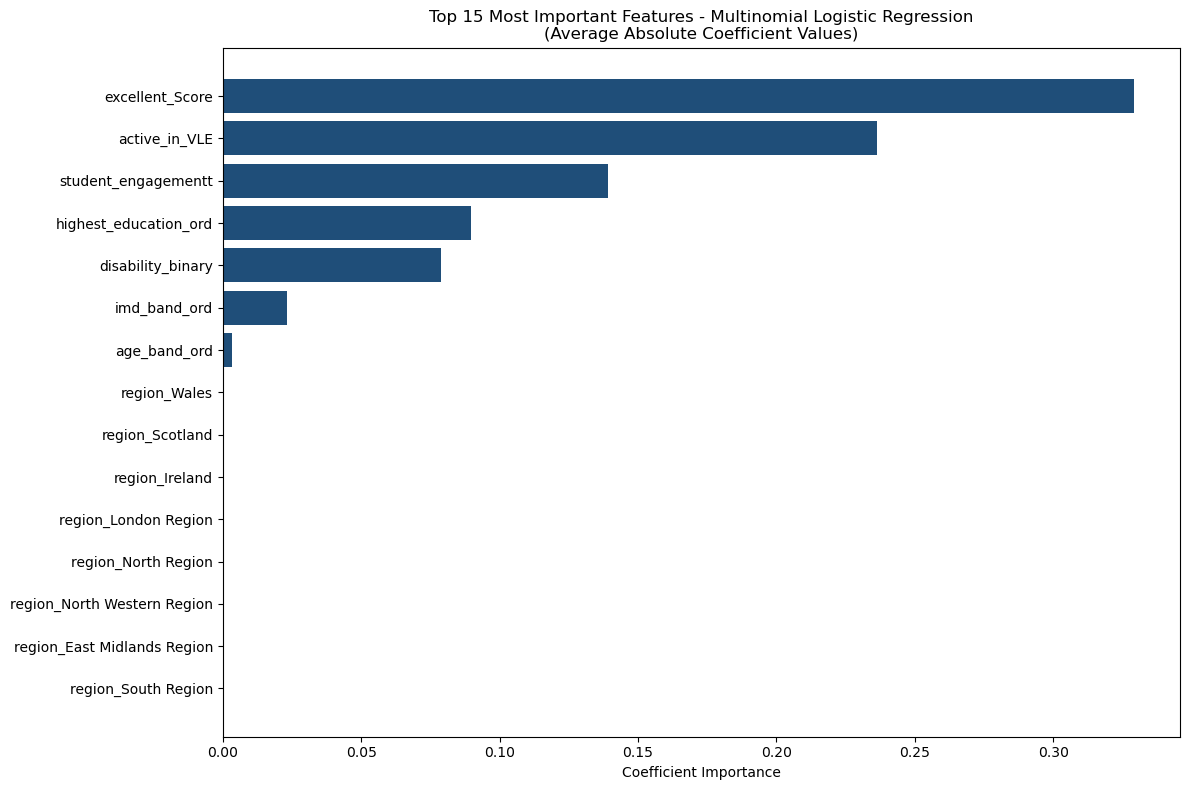

In [56]:
# ================================================================
# 12. COEFFICIENT ANALYSIS (LOGISTIC REGRESSION FEATURE IMPORTANCE)
# ================================================================

print(f"\n🔍 COEFFICIENT ANALYSIS")
print("=" * 60)

# Get feature names
try:
    if hasattr(X_train_lr, 'columns'):
        feature_names = X_train_lr.columns.tolist()
    else:
        feature_names = [f'feature_{i}' for i in range(X_train_lr.shape[1])]
except:
    feature_names = [f'feature_{i}' for i in range(best_lr_model.coef_.shape[1])]

# Get coefficients from the best model
n_classes = len(class_labels)

if n_classes == 2:
    # Binary classification
    coefficients = best_lr_model.coef_[0]
    abs_coefficients = np.abs(coefficients)
    
    # Create coefficient DataFrame
    coef_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefficients,
        'abs_coefficient': abs_coefficients
    }).sort_values('abs_coefficient', ascending=False)
    
    print(f"📊 TOP 10 MOST IMPORTANT FEATURES (by absolute coefficient):")
    print("-" * 50)
    for i, (_, row) in enumerate(coef_df.head(10).iterrows(), 1):
        print(f"{i:2d}. {row['feature']:25s}: {row['coefficient']:8.4f} (|{row['abs_coefficient']:.4f}|)")

else:
    # Multinomial classification - show average absolute coefficient across classes
    avg_abs_coef = np.mean(np.abs(best_lr_model.coef_), axis=0)
    
    # Create coefficient DataFrame
    coef_df = pd.DataFrame({
        'feature': feature_names,
        'avg_abs_coefficient': avg_abs_coef
    }).sort_values('avg_abs_coefficient', ascending=False)
    
    print(f"📊 TOP 10 MOST IMPORTANT FEATURES (by average absolute coefficient):")
    print("-" * 50)
    for i, (_, row) in enumerate(coef_df.head(10).iterrows(), 1):
        print(f"{i:2d}. {row['feature']:25s}: {row['avg_abs_coefficient']:.4f}")
    
    # Show class-specific coefficients for top 5 features
    print(f"\n📋 CLASS-SPECIFIC COEFFICIENTS (Top 5 Features):")
    print("-" * 60)
    top_5_features = coef_df.head(5)['feature'].tolist()
    
    for feature in top_5_features:
        feature_idx = feature_names.index(feature)
        print(f"\n{feature}:")
        for class_idx, class_label in enumerate(class_labels):
            coef_value = best_lr_model.coef_[class_idx, feature_idx]
            print(f"   Class {class_label}: {coef_value:8.4f}")

# Visualize coefficient importance
plt.figure(figsize=(12, 8))
top_features = coef_df.head(15)
if n_classes == 2:
    plt.barh(range(len(top_features)), top_features['abs_coefficient'])
    plt.title('Top 15 Most Important Features - Multinomial Logistic Regression\n(Absolute Coefficient Values)')
else:
    plt.barh(range(len(top_features)), top_features['avg_abs_coefficient'])
    plt.title('Top 15 Most Important Features - Multinomial Logistic Regression\n(Average Absolute Coefficient Values)')

plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Coefficient Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [57]:
# ================================================================
# 13. FINAL OPTIMIZED MODEL CODE
# ================================================================

print(f"\n💾 OPTIMIZED MODEL FOR PRODUCTION")
print("=" * 60)

print("✅ Your optimized Multinomial Logistic Regression model:")
print()
print("# Copy-paste this code to create your optimized model")
print("optimized_lr = LogisticRegression(")
for param, value in grid_search.best_params_.items():
    if isinstance(value, str):
        print(f"    {param}='{value}',")
    else:
        print(f"    {param}={value},")
print("    random_state=42,")
print("    multi_class='multinomial'")
print(")")
print()
print("# Train and use the model")
print("optimized_lr.fit(X_train_lr, y_train_lr)")
print("y_pred = optimized_lr.predict(X_test_lr)")


💾 OPTIMIZED MODEL FOR PRODUCTION
✅ Your optimized Multinomial Logistic Regression model:

# Copy-paste this code to create your optimized model
optimized_lr = LogisticRegression(
    C=0.01,
    class_weight={0: 2.0939343875383525, 1: 1.312270737190865, 2: 0.48051561188290415},
    l1_ratio=0.5,
    max_iter=1000,
    penalty='l1',
    solver='saga',
    random_state=42,
    multi_class='multinomial'
)

# Train and use the model
optimized_lr.fit(X_train_lr, y_train_lr)
y_pred = optimized_lr.predict(X_test_lr)


In [58]:
# ================================================================
# 14. PERFORMANCE SUMMARY
# ================================================================

print(f"\n📈 PERFORMANCE SUMMARY")
print("=" * 60)

print(f"🎯 Optimization Results:")
print(f"   Best CV {recommended_scoring}: {grid_search.best_score_:.4f}")
print(f"   Test set accuracy:           {test_accuracy:.4f}")
print(f"   Test set F1-weighted:        {test_f1_weighted:.4f}")
print(f"   Test set F1-macro:           {test_f1_macro:.4f}")

print(f"\n⚙️  Best Hyperparameters:")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")

print(f"\n⏱️  Optimization Details:")
print(f"   Total combinations tested: {total_combinations}")
print(f"   Cross-validation folds: 3")
print(f"   Runtime: {total_time/60:.1f} minutes")
print(f"   Primary scoring metric: {recommended_scoring}")

print(f"\n🎉 OPTIMIZATION COMPLETE!")
print("Your Multinomial Logistic Regression model is now optimized and ready to use!")


📈 PERFORMANCE SUMMARY
🎯 Optimization Results:
   Best CV dropout_recall: 0.6684
   Test set accuracy:           0.4808
   Test set F1-weighted:        0.4880
   Test set F1-macro:           0.4157

⚙️  Best Hyperparameters:
   C: 0.01
   class_weight: {0: 2.0939343875383525, 1: 1.312270737190865, 2: 0.48051561188290415}
   l1_ratio: 0.5
   max_iter: 1000
   penalty: l1
   solver: saga

⏱️  Optimization Details:
   Total combinations tested: 450
   Cross-validation folds: 3
   Runtime: 4.1 minutes
   Primary scoring metric: dropout_recall

🎉 OPTIMIZATION COMPLETE!
Your Multinomial Logistic Regression model is now optimized and ready to use!


In [59]:
# ================================================================
# 15. CREATE DIRECTORIES AND SAVE MODEL RESULTS
# ================================================================

print(f"\n💾 SAVING MODEL RESULTS")
print("=" * 60)

# Create directory structure
base_dir = "../Data"  # Go up one level from Notebooks to reach Data
model_metrics_dir = os.path.join(base_dir, "model_metrics")
models_dir = os.path.join(model_metrics_dir, "models")
metrics_dir = os.path.join(model_metrics_dir, "metrics")
reports_dir = os.path.join(model_metrics_dir, "reports")

# Create directories if they don't exist
os.makedirs(models_dir, exist_ok=True)
os.makedirs(metrics_dir, exist_ok=True) 
os.makedirs(reports_dir, exist_ok=True)

print(f"✅ Created directory structure:")
print(f"   📁 {model_metrics_dir}")
print(f"   📁 {models_dir}")
print(f"   📁 {metrics_dir}")
print(f"   📁 {reports_dir}")


💾 SAVING MODEL RESULTS
✅ Created directory structure:
   📁 ../Data\model_metrics
   📁 ../Data\model_metrics\models
   📁 ../Data\model_metrics\metrics
   📁 ../Data\model_metrics\reports


In [60]:
# ================================================================
# 16. SAVE THE TRAINED MODEL
# ================================================================

print(f"\n🤖 SAVING TRAINED MODEL")
print("=" * 60)

# Create model name
model_name = "multinomial_logistic_regression_optimized"

# Save the trained model
model_path = os.path.join(models_dir, f"{model_name}.pkl")
joblib.dump(best_lr_model, model_path)

print(f"✅ Model saved to: {model_path}")
print(f"📏 Model file size: {os.path.getsize(model_path) / (1024*1024):.2f} MB")


🤖 SAVING TRAINED MODEL
✅ Model saved to: ../Data\model_metrics\models\multinomial_logistic_regression_optimized.pkl
📏 Model file size: 0.00 MB


In [61]:
# ================================================================
# 17. SAVE MODEL METRICS AND PERFORMANCE DATA
# ================================================================

print(f"\n📊 SAVING PERFORMANCE METRICS")
print("=" * 60)

# Helper function to convert numpy types to Python native types
def convert_numpy_types(obj):
    """Convert numpy types to Python native types for JSON serialization"""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    else:
        return obj

# Prepare comprehensive metrics dictionary
model_metrics = {
    "model_info": {
        "model_name": "Multinomial Logistic Regression",
        "optimization_method": "GridSearchCV",
        "primary_scoring_metric": recommended_scoring,
        "total_runtime_minutes": round(total_time/60, 2)
    },
    "dataset_info": {
        "training_samples": int(X_train_lr.shape[0]),
        "test_samples": int(X_test_lr.shape[0]),
        "n_features": int(X_train_lr.shape[1]),
        "n_classes": int(len(np.unique(y_train_lr))),
        "class_distribution": {str(k): int(v) for k, v in class_counts.items()}
    },
    "hyperparameters": {
        "best_params": convert_numpy_types(grid_search.best_params_),
        "total_combinations_tested": int(total_combinations),
        "cv_folds": cv_folds
    },
    "cross_validation_results": {
        "best_cv_score": float(grid_search.best_score_),
        "cv_scores_by_metric": {}
    },
    "test_set_performance": {
        "accuracy": float(test_accuracy),
        "f1_weighted": float(test_f1_weighted),
        "f1_macro": float(test_f1_macro)
    },
    "coefficient_analysis": {
        "top_10_features": [
            {
                "feature": str(row['feature']),
                "importance": float(row['avg_abs_coefficient']) if n_classes > 2 else float(row['abs_coefficient'])
            }
            for _, row in coef_df.head(10).iterrows()
        ]
    }
}

# Add detailed CV results for all metrics
cv_results = grid_search.cv_results_
best_index = grid_search.best_index_

for metric_name in scoring_metrics.keys():
    score_key = f'mean_test_{metric_name}'
    std_key = f'std_test_{metric_name}'
    
    if score_key in cv_results:
        model_metrics["cross_validation_results"]["cv_scores_by_metric"][metric_name] = {
            "mean": float(cv_results[score_key][best_index]),
            "std": float(cv_results[std_key][best_index])
        }

# Convert the entire dictionary to ensure all numpy types are handled
model_metrics = convert_numpy_types(model_metrics)

# Save metrics as JSON
metrics_path = os.path.join(metrics_dir, f"{model_name}_metrics.json")
with open(metrics_path, 'w') as f:
    json.dump(model_metrics, f, indent=2)

print(f"✅ Metrics saved to: {metrics_path}")



📊 SAVING PERFORMANCE METRICS
✅ Metrics saved to: ../Data\model_metrics\metrics\multinomial_logistic_regression_optimized_metrics.json


In [62]:
# ================================================================
# 18. SAVE DETAILED CLASSIFICATION REPORT
# ================================================================

print(f"\n📋 SAVING CLASSIFICATION REPORT")
print("=" * 60)

# Generate detailed classification report
from sklearn.metrics import classification_report

# Get classification report as dictionary
class_report_dict = classification_report(y_test_lr, y_pred_test, output_dict=True)

# Save classification report
report_path = os.path.join(reports_dir, f"{model_name}_classification_report.json")
with open(report_path, 'w') as f:
    json.dump(class_report_dict, f, indent=2)

print(f"✅ Classification report saved to: {report_path}")


📋 SAVING CLASSIFICATION REPORT
✅ Classification report saved to: ../Data\model_metrics\reports\multinomial_logistic_regression_optimized_classification_report.json


In [63]:
# ================================================================
# 19. SAVE CONFUSION MATRIX DATA
# ================================================================

print(f"\n🔢 SAVING CONFUSION MATRIX")
print("=" * 60)

# Save confusion matrix data
confusion_matrix_data = {
    "confusion_matrix": cm.tolist(),
    "class_labels": sorted(np.unique(y_train_lr).tolist()),
    "model_name": model_name
}

cm_path = os.path.join(metrics_dir, f"{model_name}_confusion_matrix.json")
with open(cm_path, 'w') as f:
    json.dump(confusion_matrix_data, f, indent=2)

print(f"✅ Confusion matrix saved to: {cm_path}")


🔢 SAVING CONFUSION MATRIX
✅ Confusion matrix saved to: ../Data\model_metrics\metrics\multinomial_logistic_regression_optimized_confusion_matrix.json


In [64]:
# ================================================================
# 20. SAVE COEFFICIENT ANALYSIS DATA
# ================================================================

print(f"\n🎯 SAVING COEFFICIENT ANALYSIS")
print("=" * 60)

# Save as JSON
coef_json_path = os.path.join(metrics_dir, f"{model_name}_coefficients.json")
coef_json = {
    "model_name": model_name,
    "coefficient_analysis": [
        {
            "rank": i + 1,
            "feature": row['feature'],
            "importance": float(row['avg_abs_coefficient']) if n_classes > 2 else float(row['abs_coefficient'])
        }
        for i, (_, row) in enumerate(coef_df.iterrows())
    ]
}

# Add class-specific coefficients for multinomial case
if n_classes > 2:
    coef_json["class_specific_coefficients"] = {}
    for class_idx, class_label in enumerate(class_labels):
        coef_json["class_specific_coefficients"][str(class_label)] = [
            {
                "feature": feature_names[feat_idx],
                "coefficient": float(best_lr_model.coef_[class_idx, feat_idx])
            }
            for feat_idx in range(len(feature_names))
        ]

with open(coef_json_path, 'w') as f:
    json.dump(coef_json, f, indent=2)

print(f"✅ Coefficient analysis JSON saved to: {coef_json_path}")


🎯 SAVING COEFFICIENT ANALYSIS
✅ Coefficient analysis JSON saved to: ../Data\model_metrics\metrics\multinomial_logistic_regression_optimized_coefficients.json


In [65]:
# ================================================================
# 21. CREATE MODEL LOADING INSTRUCTIONS
# ================================================================

print(f"\n📖 SAVING MODEL USAGE INSTRUCTIONS")
print("=" * 60)

# Create instructions file
instructions = f"""
MULTINOMIAL LOGISTIC REGRESSION MODEL USAGE INSTRUCTIONS
=======================================================

Model Information:
- Model Name: {model_name}
- Model Type: Multinomial Logistic Regression (Optimized)
- File Location: {model_path}

LOADING THE MODEL:
-----------------
```python
import joblib
import pandas as pd
import numpy as np

# Load the trained model
model = joblib.load('{model_path}')

# Make predictions on new data
# Ensure your new data has the same features as training data
predictions = model.predict(X_new)
prediction_probabilities = model.predict_proba(X_new)

# Get coefficients
coefficients = model.coef_
intercept = model.intercept_
```

BEST HYPERPARAMETERS:
-------------------
{json.dumps(grid_search.best_params_, indent=2)}

PERFORMANCE METRICS:
------------------
- Test Accuracy: {test_accuracy:.4f}
- Test F1-Weighted: {test_f1_weighted:.4f}
- Test F1-Macro: {test_f1_macro:.4f}
- Best CV Score ({recommended_scoring}): {grid_search.best_score_:.4f}

TOP 5 IMPORTANT FEATURES:
-----------------------
"""

for i, (_, row) in enumerate(coef_df.head(5).iterrows(), 1):
    if n_classes > 2:
        instructions += f"{i}. {row['feature']}: {row['avg_abs_coefficient']:.4f}\n"
    else:
        instructions += f"{i}. {row['feature']}: {row['abs_coefficient']:.4f}\n"

instructions += f"""

FILES SAVED:
-----------
- Model: {model_path}
- Metrics: {metrics_path}
- Classification Report: {report_path}
- Confusion Matrix: {cm_path}
- Coefficients: {coef_json_path}
- Usage Instructions: This file

NOTES:
-----
- This model was optimized using GridSearchCV
- Total combinations tested: {total_combinations}
- Cross-validation: 3-fold
- Optimization runtime: {total_time/60:.1f} minutes
- Primary scoring metric: {recommended_scoring}
- Model type: Multinomial (can handle multi-class problems)
"""

instructions_path = os.path.join(model_metrics_dir, f"{model_name}_USAGE_INSTRUCTIONS.txt")
with open(instructions_path, 'w') as f:
    f.write(instructions)

print(f"✅ Usage instructions saved to: {instructions_path}")



📖 SAVING MODEL USAGE INSTRUCTIONS
✅ Usage instructions saved to: ../Data\model_metrics\multinomial_logistic_regression_optimized_USAGE_INSTRUCTIONS.txt


In [66]:
# ================================================================
# 22. SUMMARY OF SAVED FILES
# ================================================================

print(f"\n📁 COMPLETE SAVE SUMMARY")
print("=" * 60)

saved_files = [
    ("Trained Model", model_path),
    ("Metrics (JSON)", metrics_path),
    ("Classification Report (JSON)", report_path),
    ("Confusion Matrix", cm_path),
    ("Coefficient Analysis (JSON)", coef_json_path),
    ("Usage Instructions", instructions_path)
]

print("✅ All files successfully saved:")
for file_type, file_path in saved_files:
    file_size = os.path.getsize(file_path)
    if file_size > 1024*1024:
        size_str = f"{file_size/(1024*1024):.2f} MB"
    elif file_size > 1024:
        size_str = f"{file_size/1024:.2f} KB"
    else:
        size_str = f"{file_size} bytes"
    
    print(f"   📄 {file_type:25s}: {os.path.basename(file_path):40s} ({size_str})")

print(f"\n🎉 MODEL EXPORT COMPLETE!")
print(f"📂 All files are stored in: {model_metrics_dir}")
print(f"🔄 Model ID: {model_name}")

# Return model identifier for future reference
model_identifier = {
    "model_id": model_name,
    "model_path": model_path,
    "metrics_path": metrics_path
}

print(f"\n💡 To load this model later:")
print(f"   model = joblib.load('{model_path}')")


📁 COMPLETE SAVE SUMMARY
✅ All files successfully saved:
   📄 Trained Model            : multinomial_logistic_regression_optimized.pkl (2.25 KB)
   📄 Metrics (JSON)           : multinomial_logistic_regression_optimized_metrics.json (3.16 KB)
   📄 Classification Report (JSON): multinomial_logistic_regression_optimized_classification_report.json (807 bytes)
   📄 Confusion Matrix         : multinomial_logistic_regression_optimized_confusion_matrix.json (297 bytes)
   📄 Coefficient Analysis (JSON): multinomial_logistic_regression_optimized_coefficients.json (7.75 KB)
   📄 Usage Instructions       : multinomial_logistic_regression_optimized_USAGE_INSTRUCTIONS.txt (2.29 KB)

🎉 MODEL EXPORT COMPLETE!
📂 All files are stored in: ../Data\model_metrics
🔄 Model ID: multinomial_logistic_regression_optimized

💡 To load this model later:
   model = joblib.load('../Data\model_metrics\models\multinomial_logistic_regression_optimized.pkl')
